In [30]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

# Helper functions

In [2]:
def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def normalize(x, ax=1):
    return (x - np.mean(x, axis=ax, keepdims=True))/ (1e-8+np.std(x, axis=ax, keepdims=True))

def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

In [28]:
def get_spiking(acts):
    spikes = poisson(scale*input_acts[i]).rvs()
    return spikes

# poisson(scale*input_acts[i]).rvs()
# # nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs()

# scale = 0.1
# print(np.mean([np.corrcoef(poisson(scale*input_acts[i]).rvs(), poisson(scale*input_acts[i]).rvs())[0, 1] for i in range(100)]))
# print(np.mean([np.corrcoef(poisson(scale*acts[i]).rvs(), poisson(scale*acts[i]).rvs())[0, 1] for i in range(100)]))

# p = 0.1
# print(np.mean([np.corrcoef(nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))
# print(np.mean([np.corrcoef(nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))

In [33]:
def distance(a, b, maximum):
    dist = np.abs(a - b)
    dist = min(dist, np.abs(maximum-dist))
    return dist

# Dynamics function

In [34]:
def run_dynamics(W, inputs, divisive_normalization=30.0, dt=0.1,):
    preacts = np.zeros([num_states, N_bar])
    acts = np.zeros([num_states, N_bar])
    for s in range(steps):
        preacts = preacts*(1-divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar*dt) + dt*np.matmul(acts, W)+dt*inputs#*(s==0)
        acts = relu(preacts)   
    return preacts, acts

# Initialization

In [101]:
# Parameters
N_inp = 2000
N_bar = 2000
num_states = 100
decay_constant = 0.2
steps = 100
b=10.0
divisive_normalization = 30.0
dt = 0.1
rec_strength = 8.0
input_strength = 1.0
narrow_search_factor = 0.0
wide_search_factor = 1.0
plasticity_bias = -0.7
lr = 40.0

cache_states = [n*5 for n in range(20)] #[n*10 for n in range(10)]

In [102]:
# Initialize weight matrices
W_reconstruct = np.zeros([N_inp, N_bar])
rand_J = np.random.randn(N_bar, N_bar)
W_rec = rec_strength*(rand_J / np.sqrt(N_bar)) - (b / N_bar)
W_fantasy = np.zeros([N_bar])

In [103]:
# Make place inputs
inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        dist = distance(n, peak, N_inp)
        inputs[s, n] = np.exp(-(dist/(N_inp*decay_constant)))
inputs = inputs - np.mean(inputs, axis=1, keepdims=True)
inputs = inputs / np.std(inputs, axis=1, keepdims=True)

# Run Task

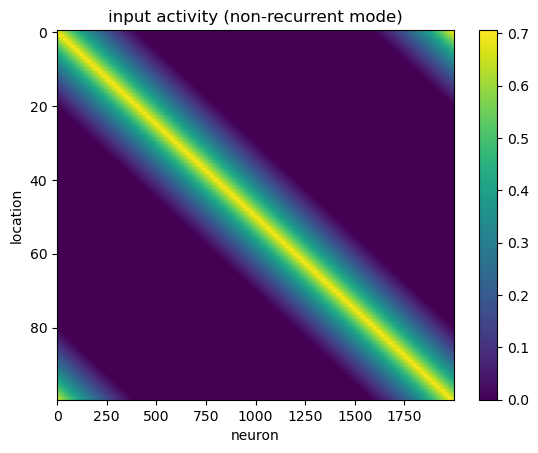

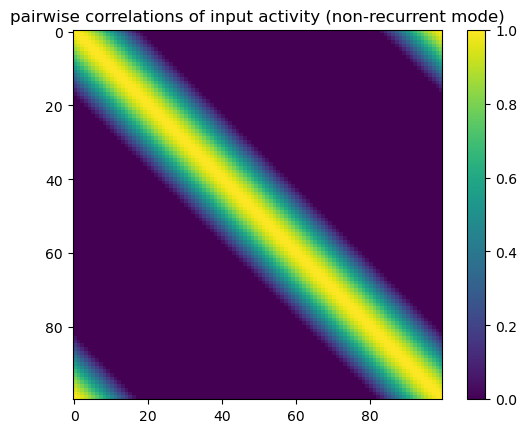

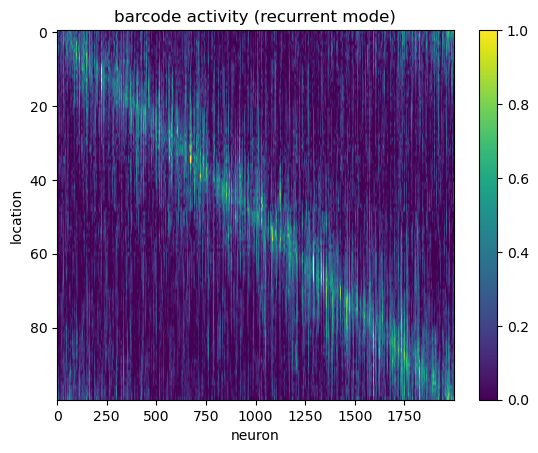

***
sparsity 0.306725


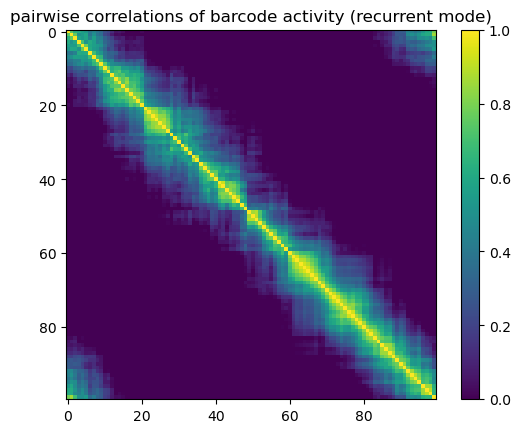

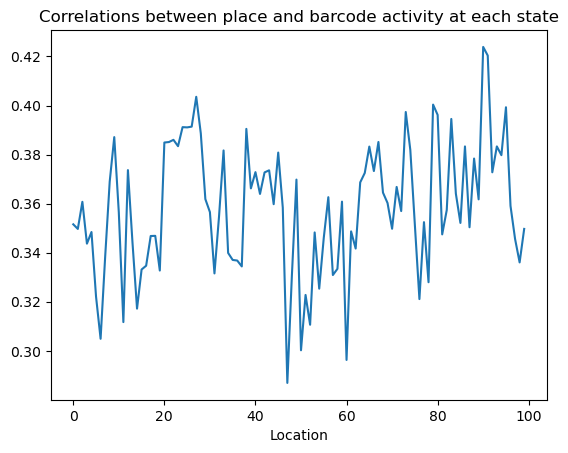

Now I just cached at location: 0


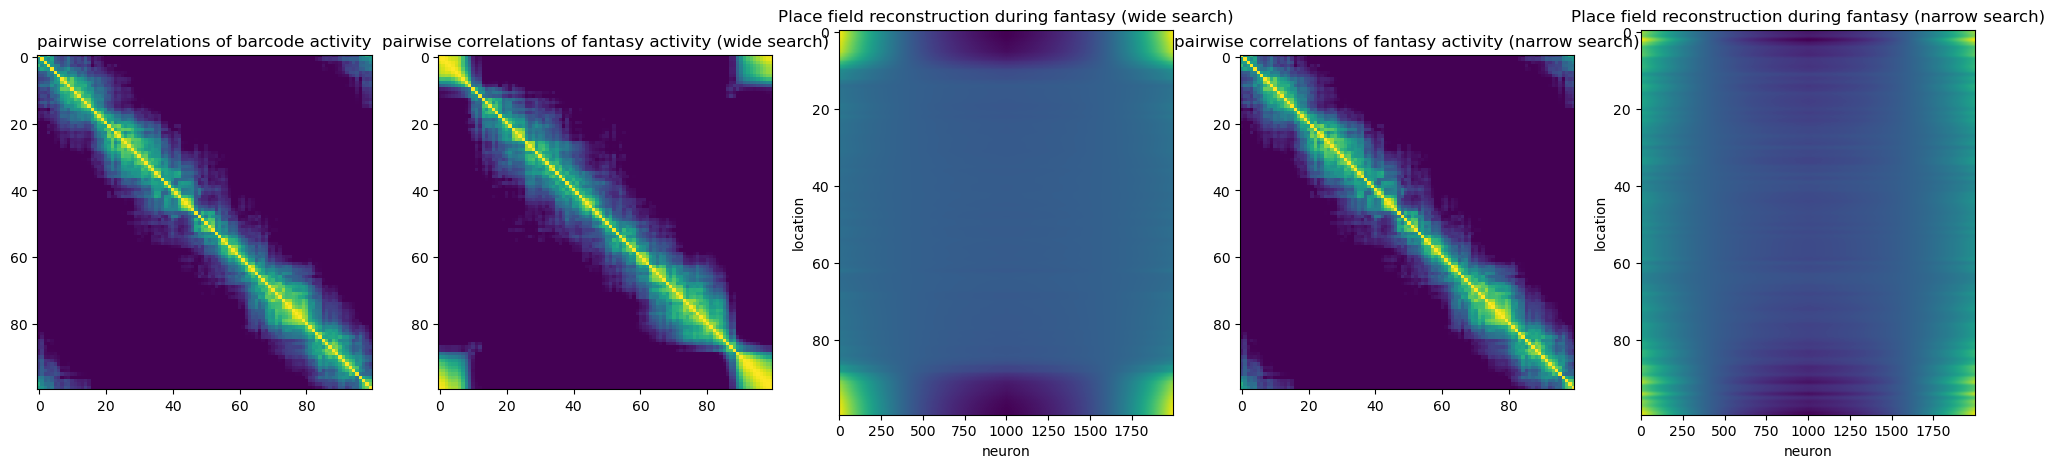

Now I just cached at location: 5


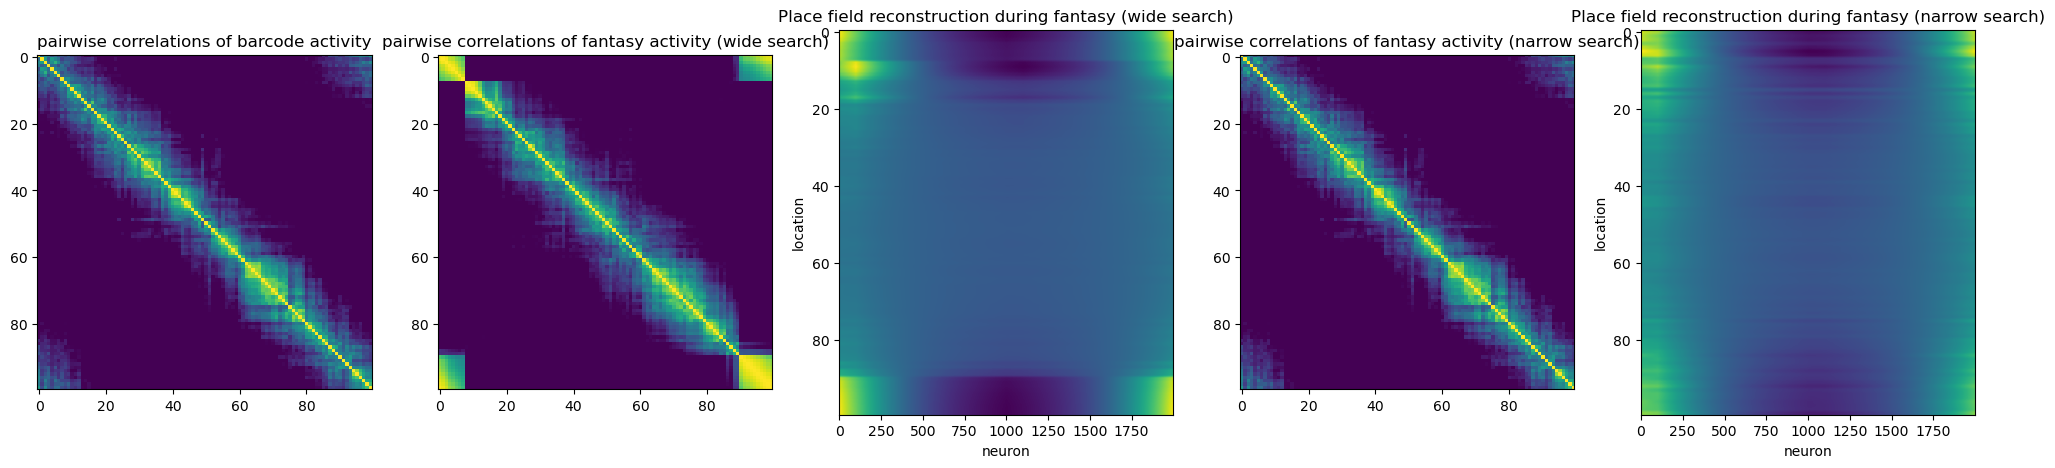

Now I just cached at location: 10


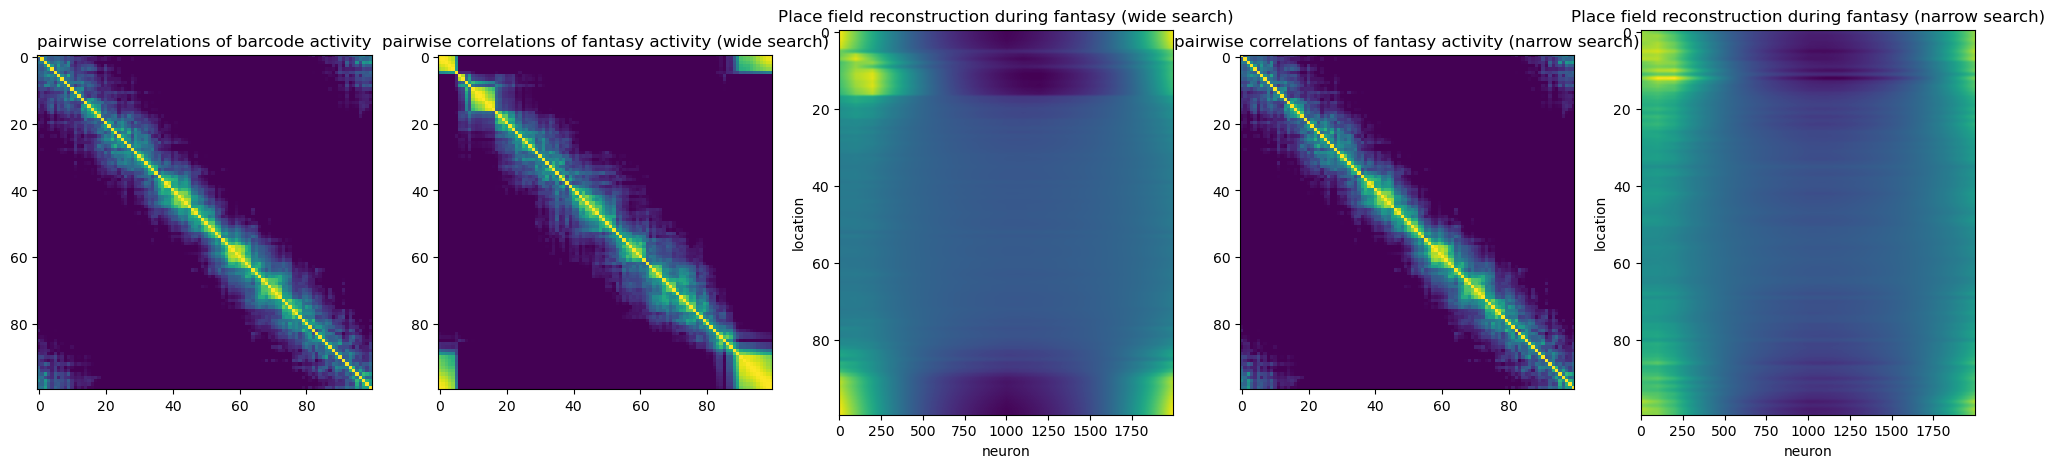

Now I just cached at location: 15


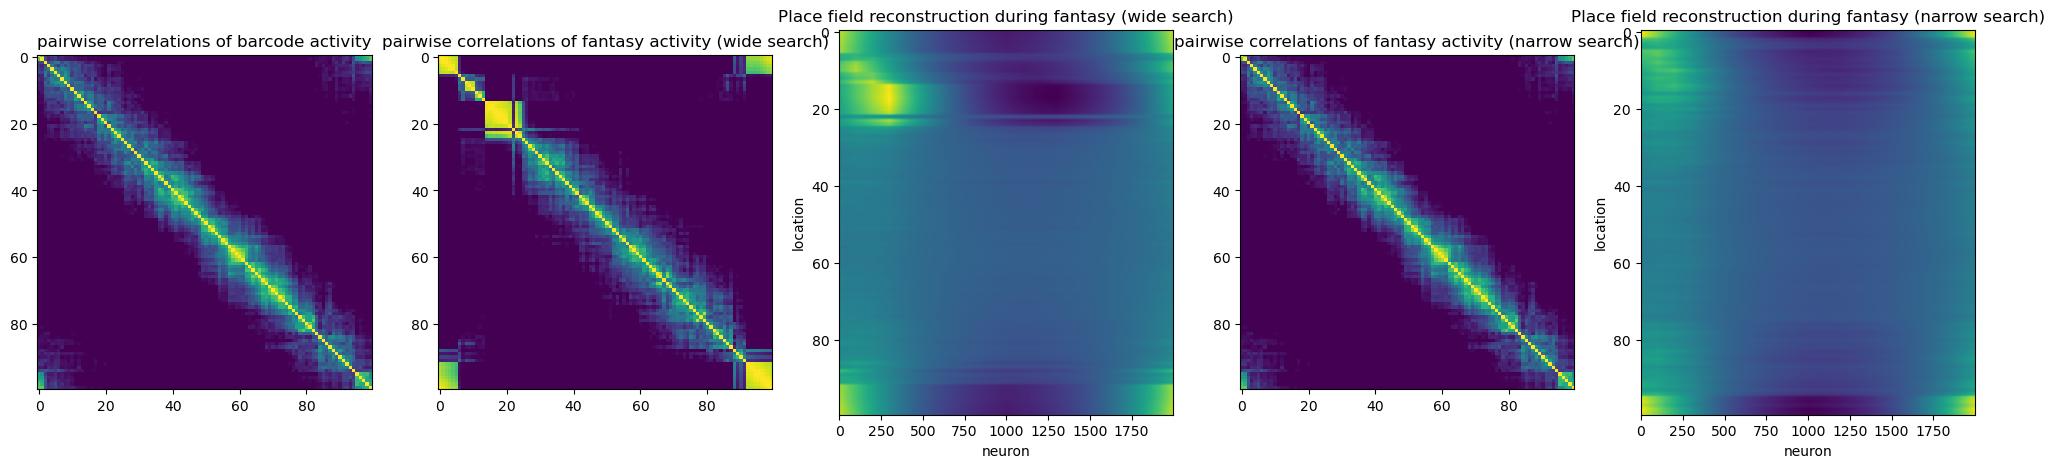

Now I just cached at location: 20


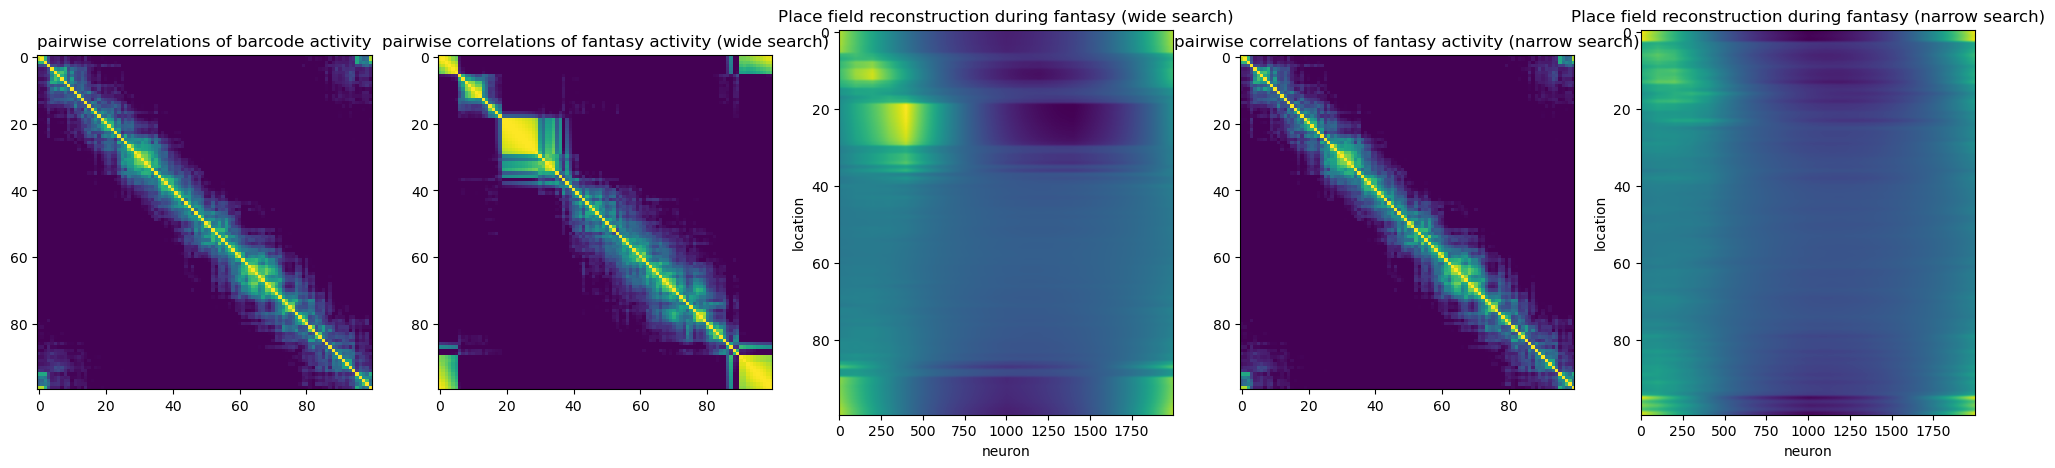

Now I just cached at location: 25


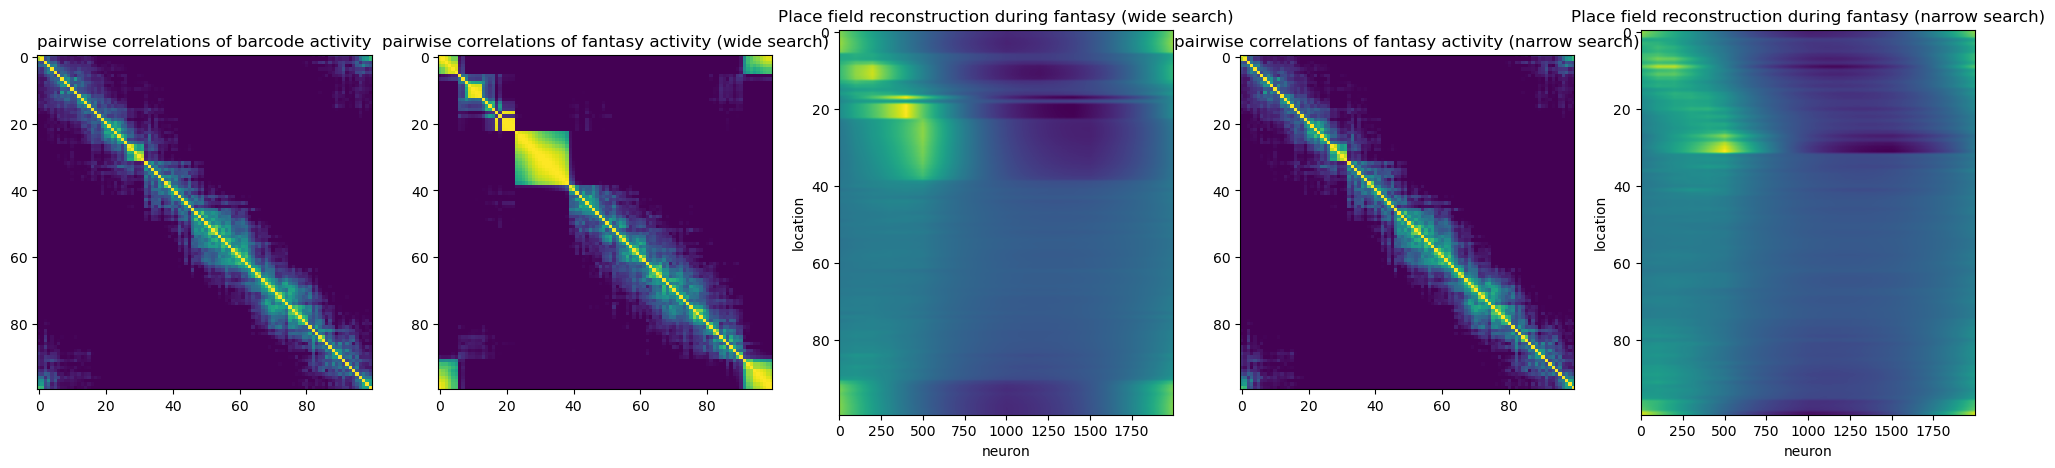

Now I just cached at location: 30


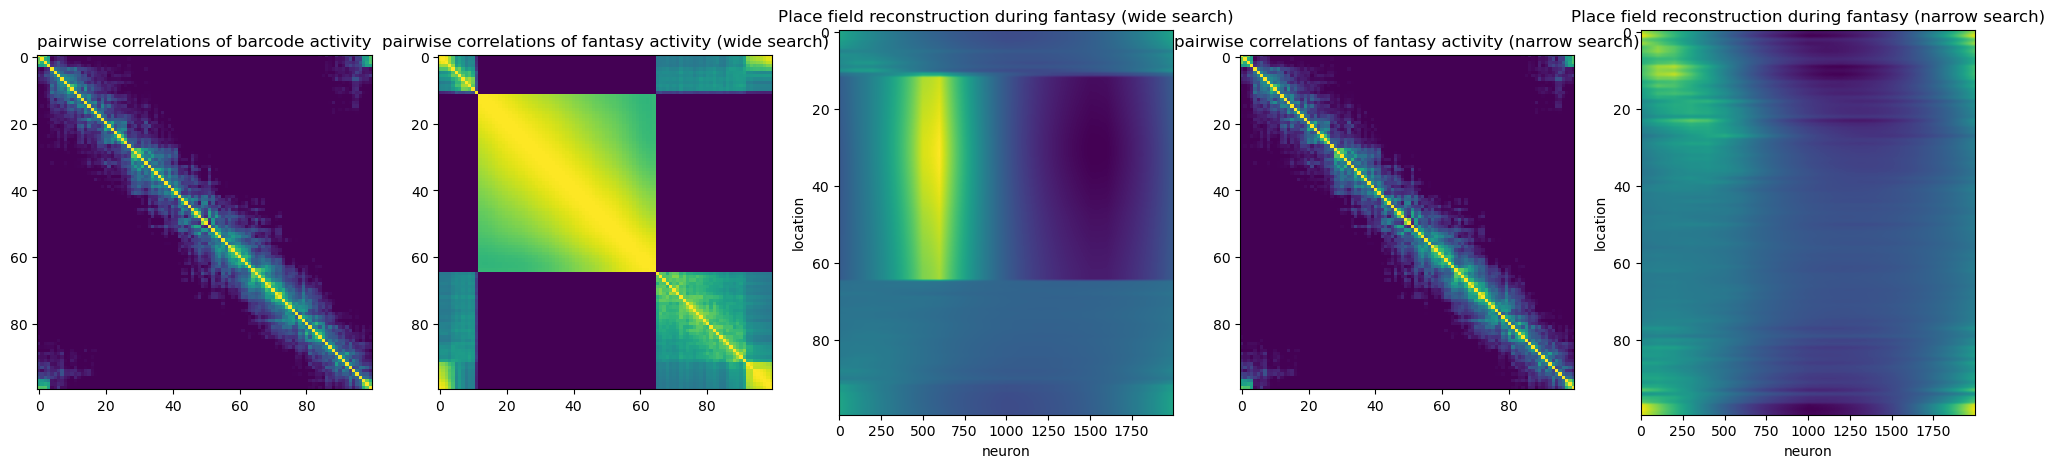

Now I just cached at location: 35


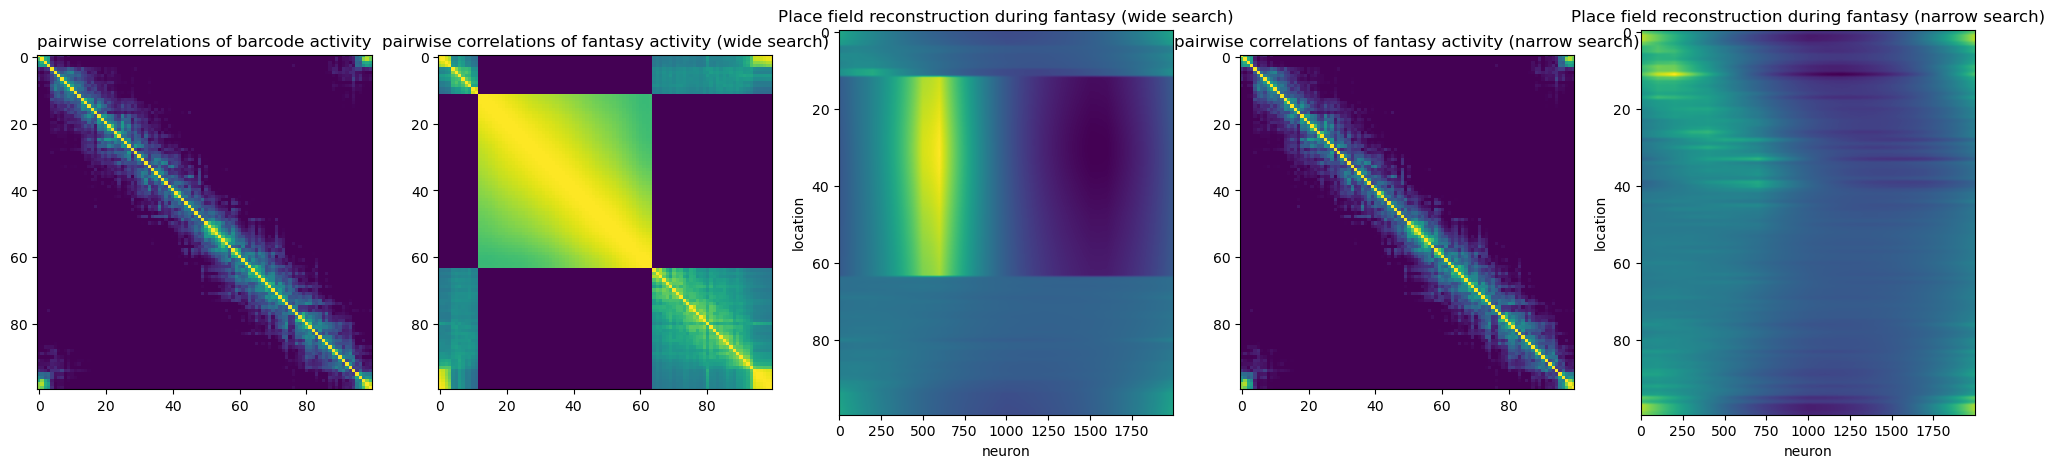

Now I just cached at location: 40


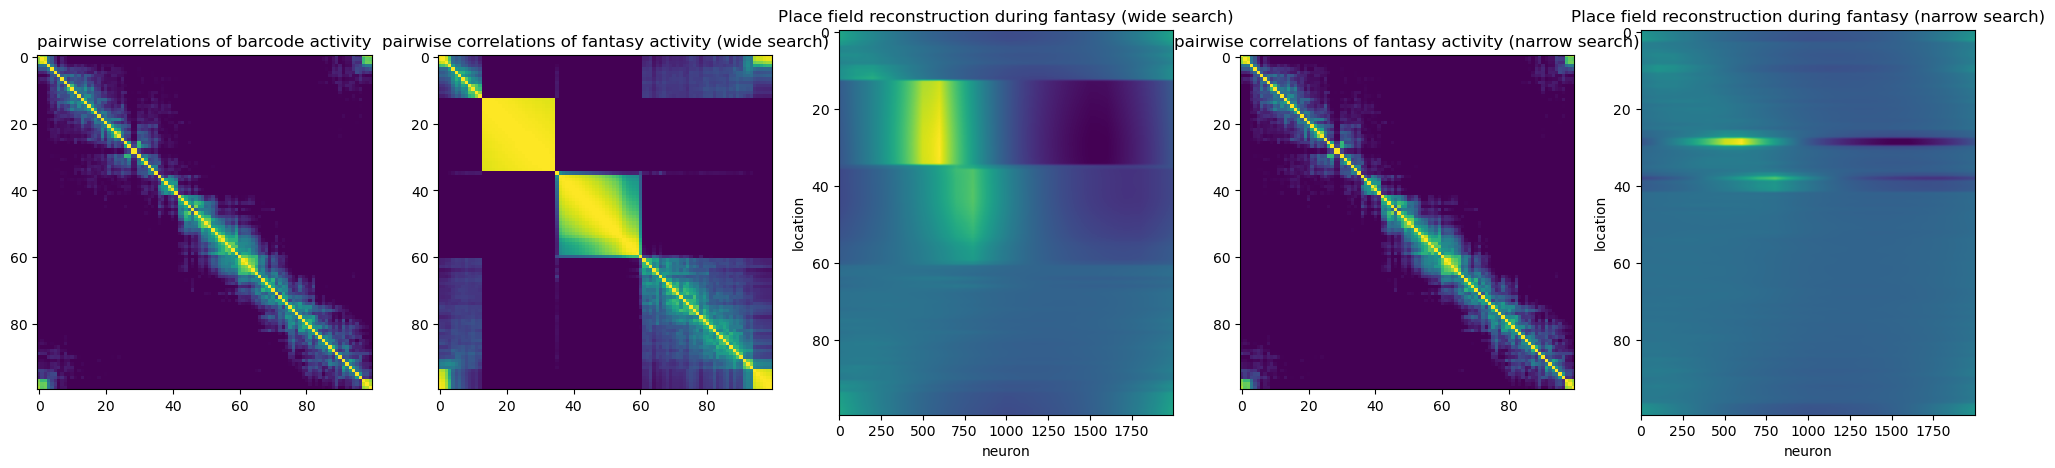

Now I just cached at location: 45


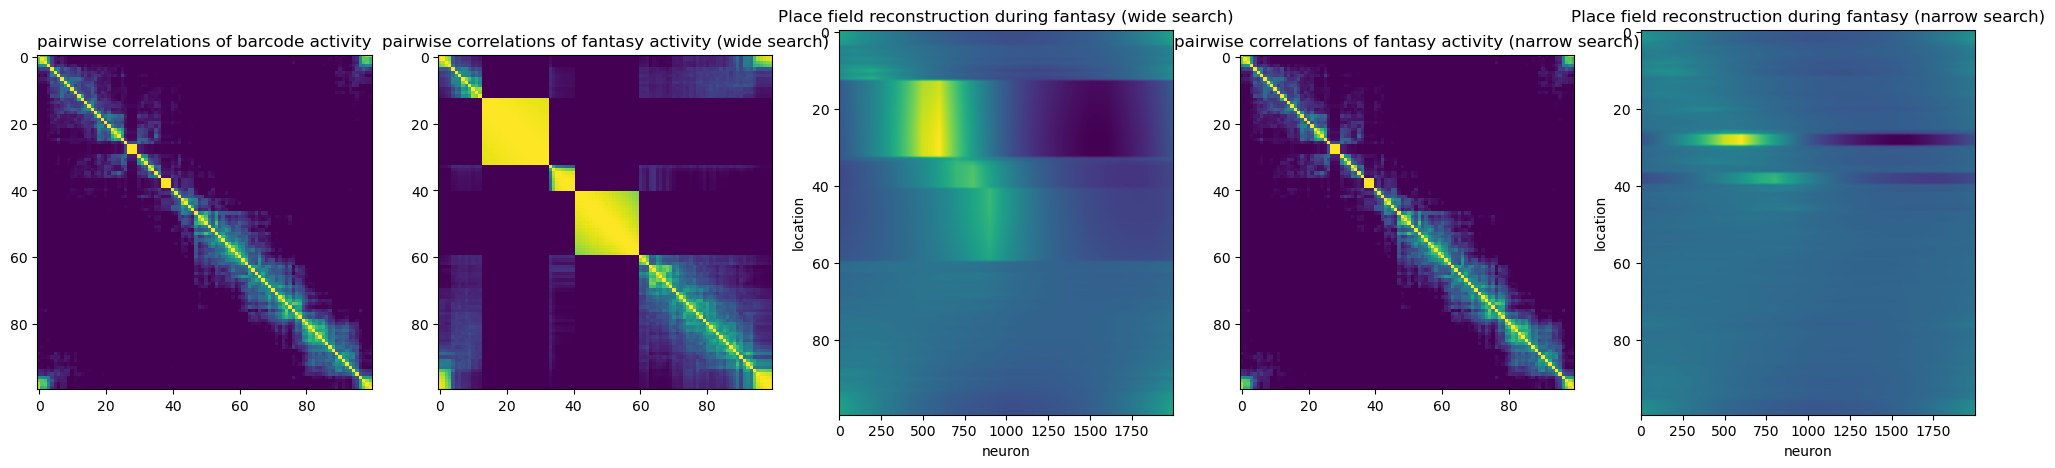

Now I just cached at location: 50


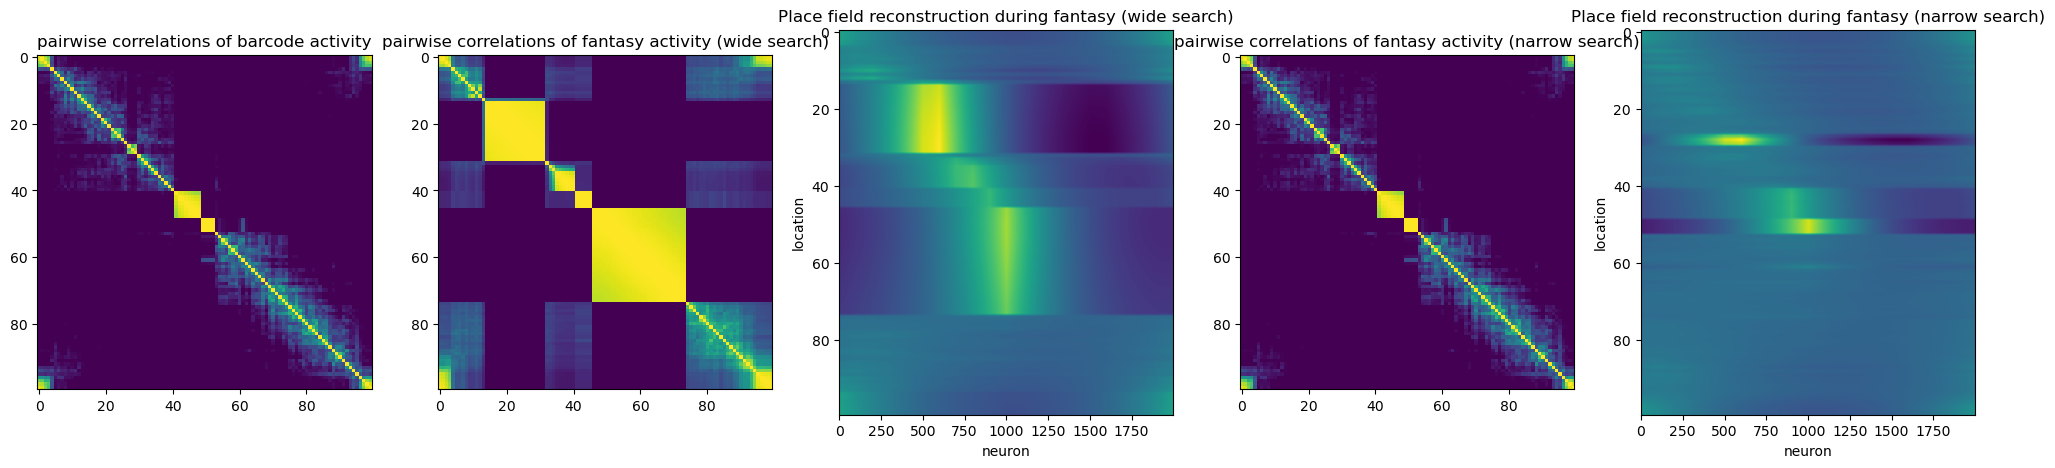

Now I just cached at location: 55


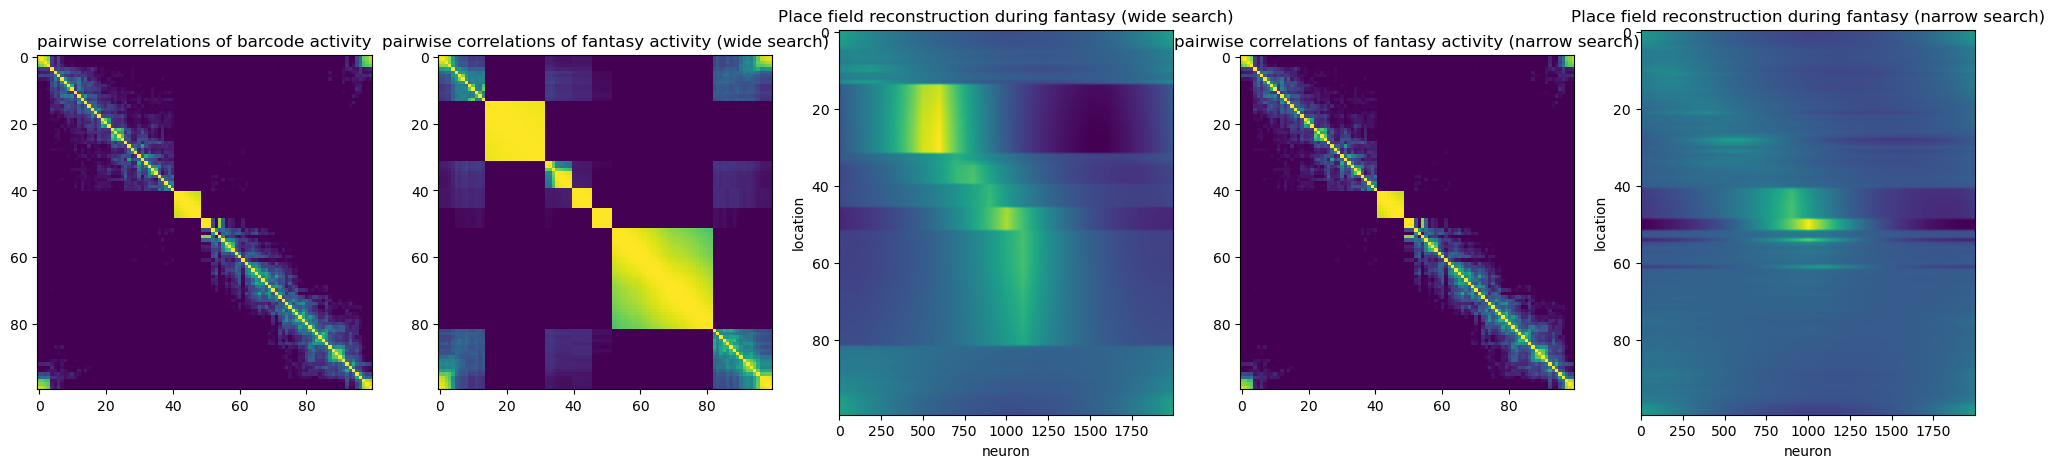

Now I just cached at location: 60


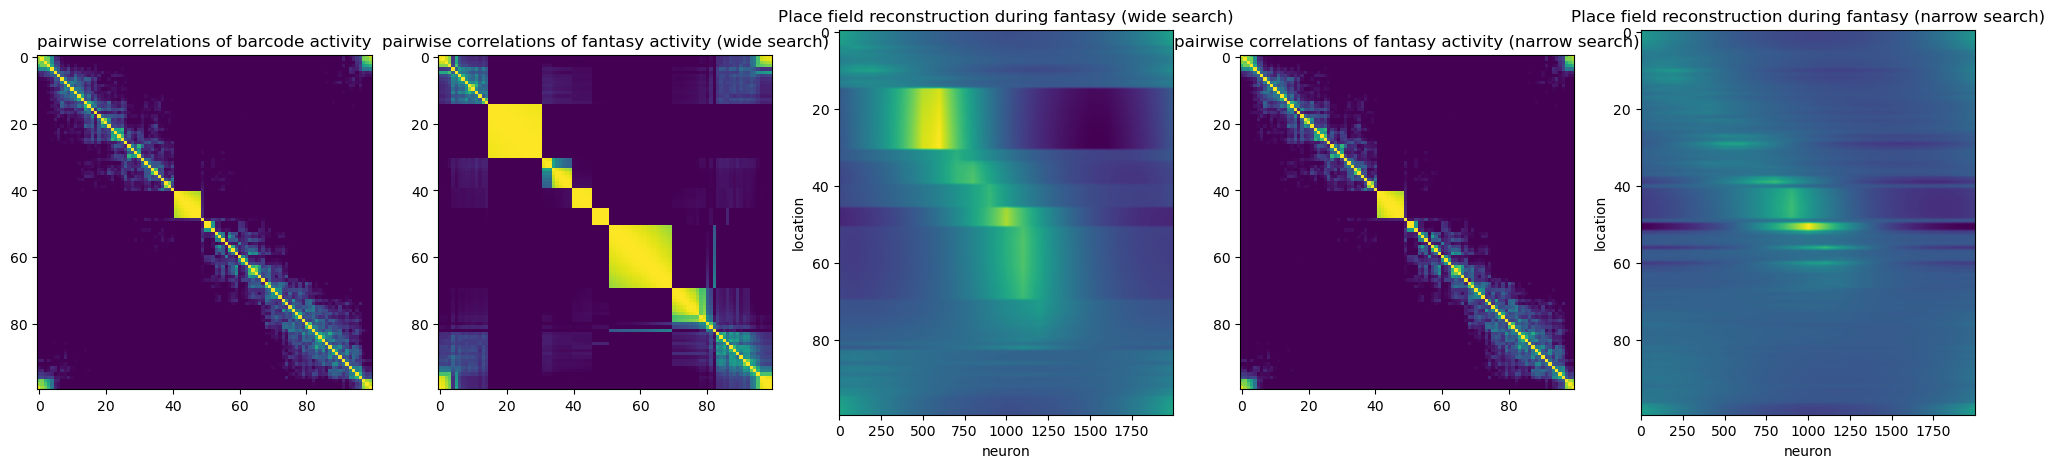

Now I just cached at location: 65


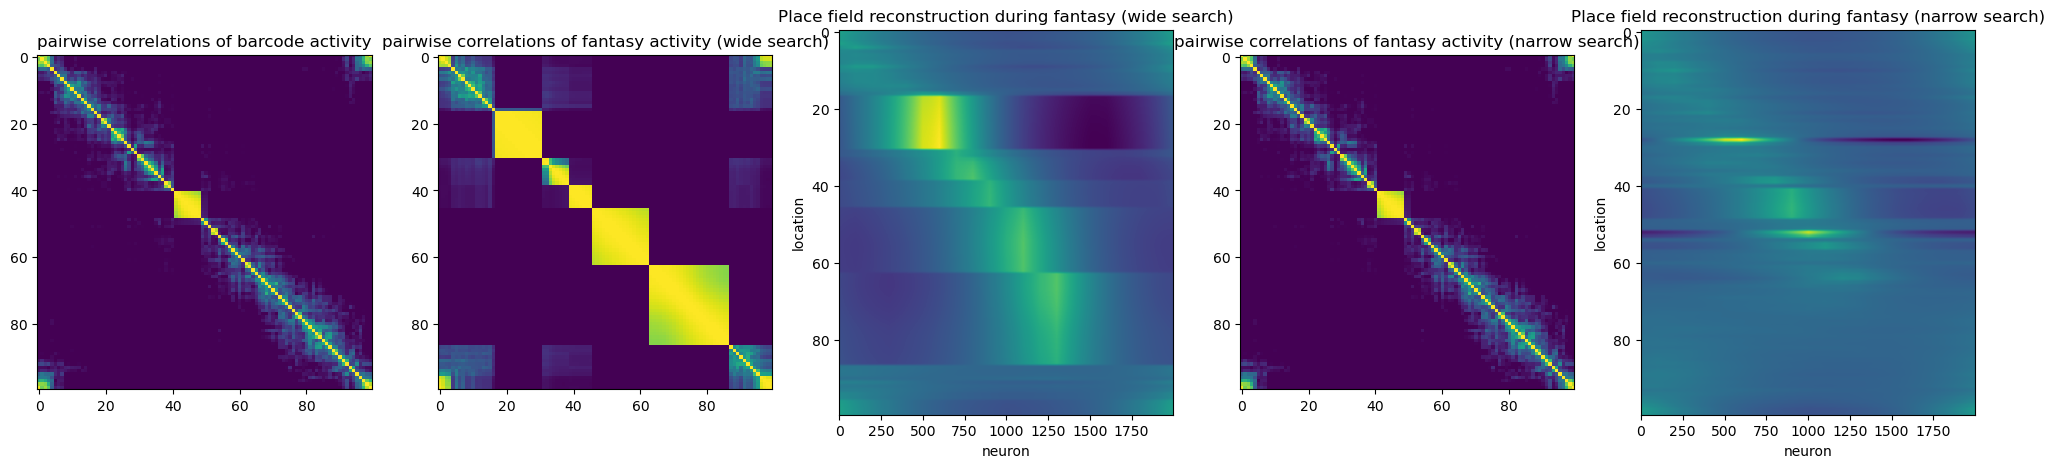

Now I just cached at location: 70


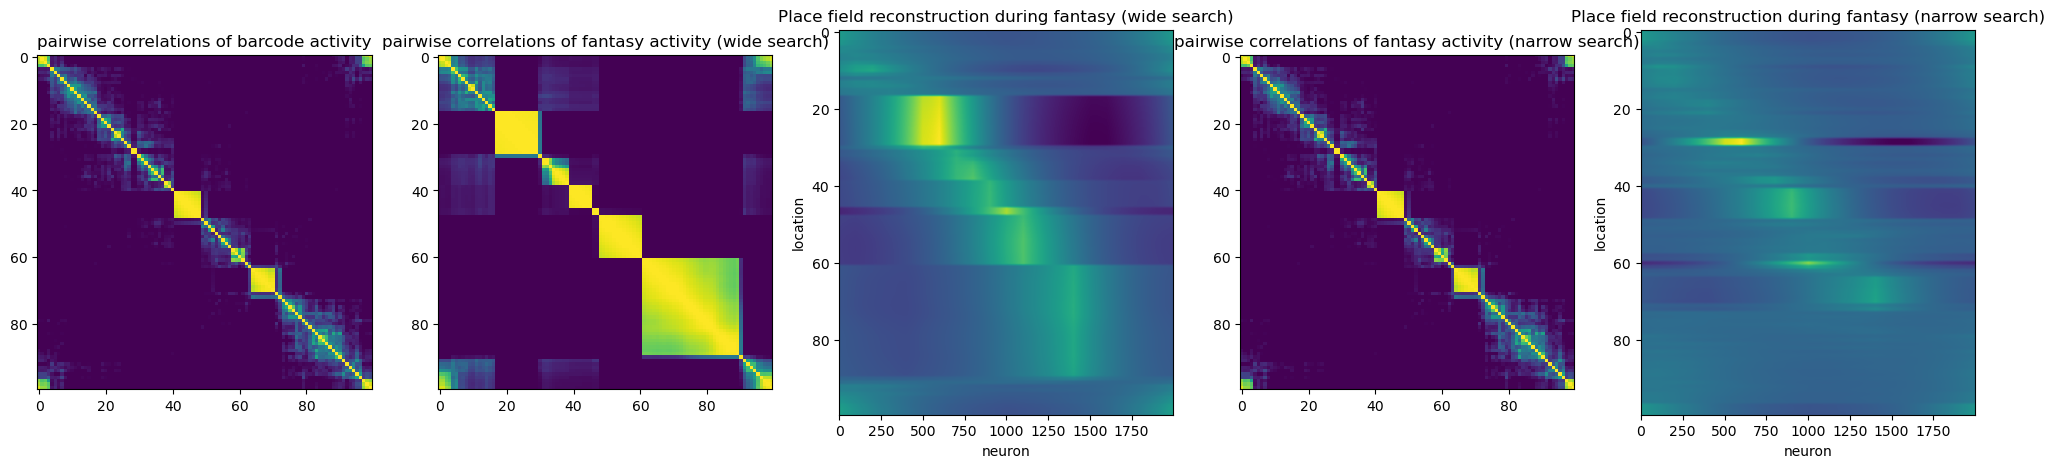

Now I just cached at location: 75


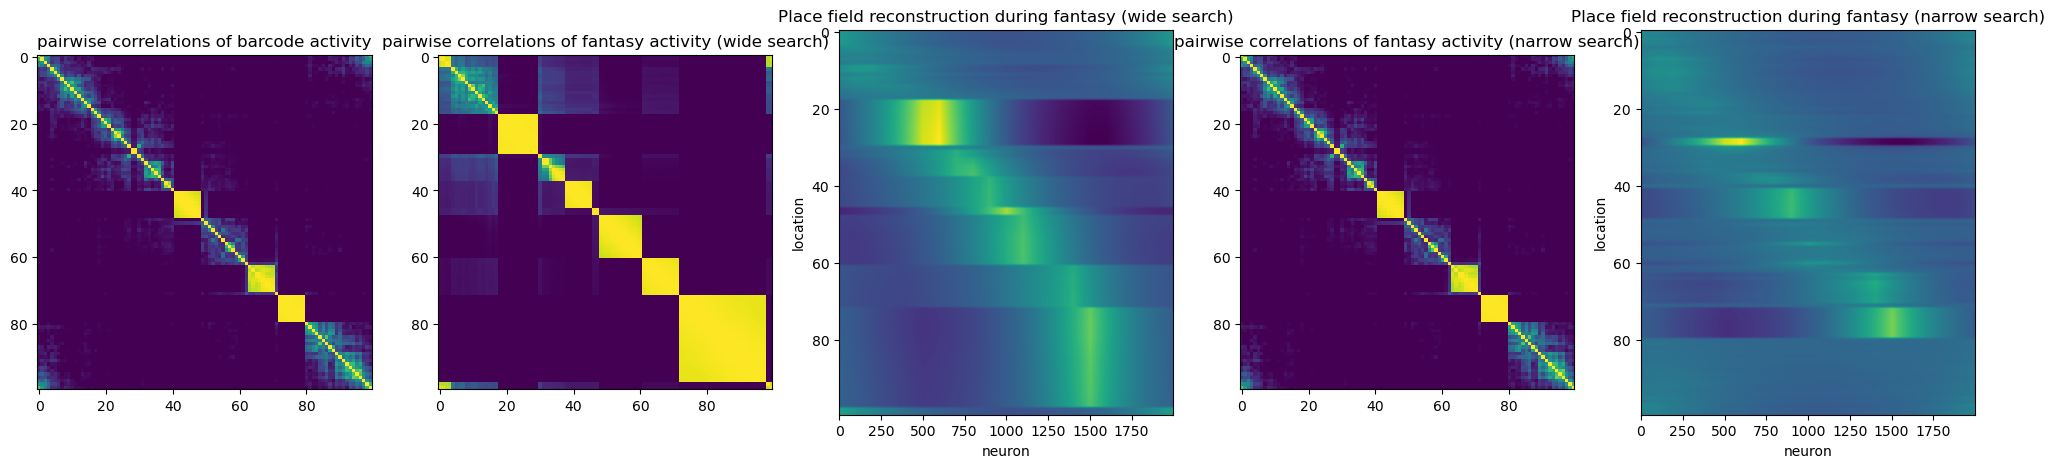

Now I just cached at location: 80


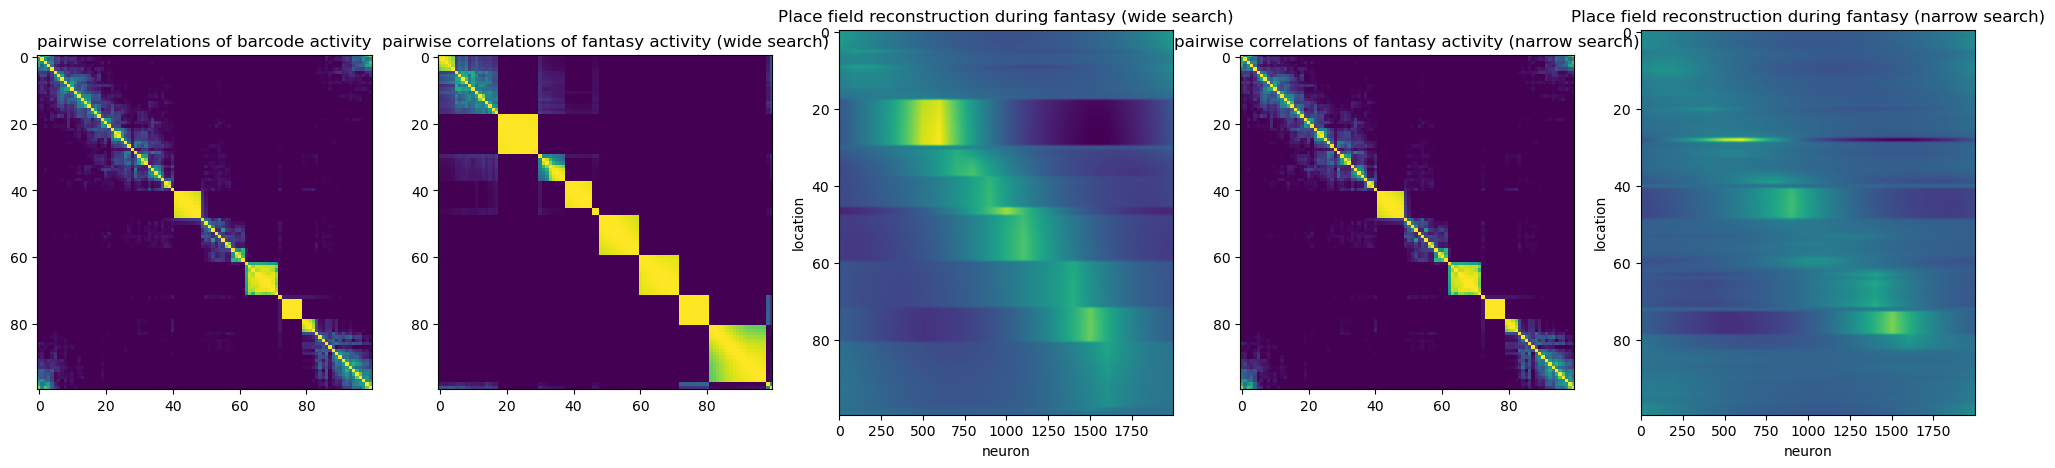

Now I just cached at location: 85


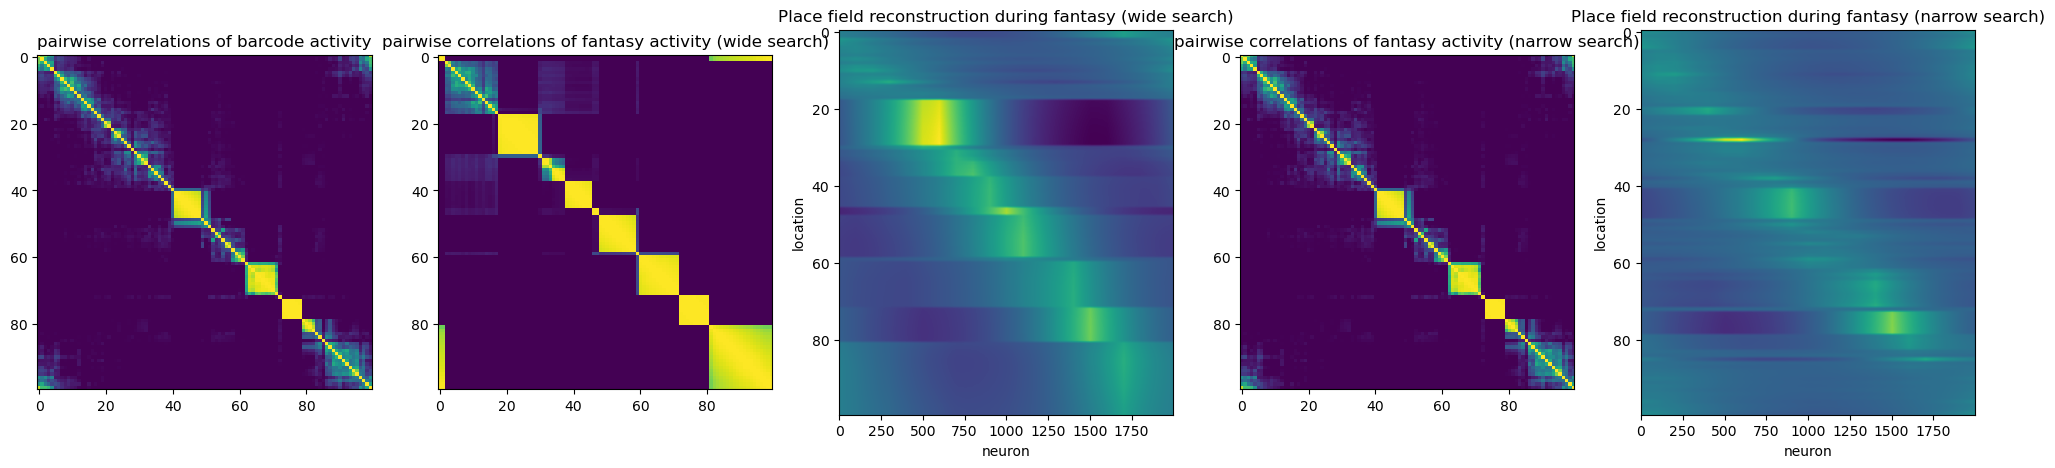

Now I just cached at location: 90


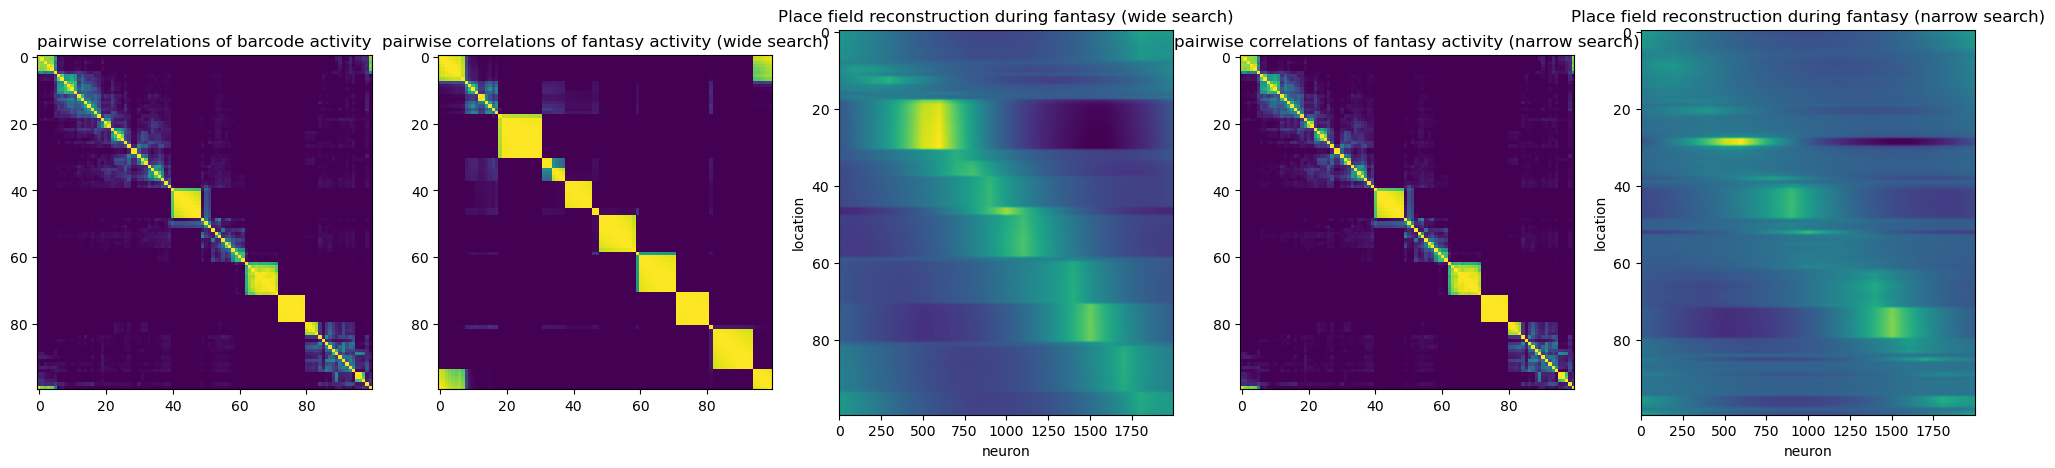

Now I just cached at location: 95


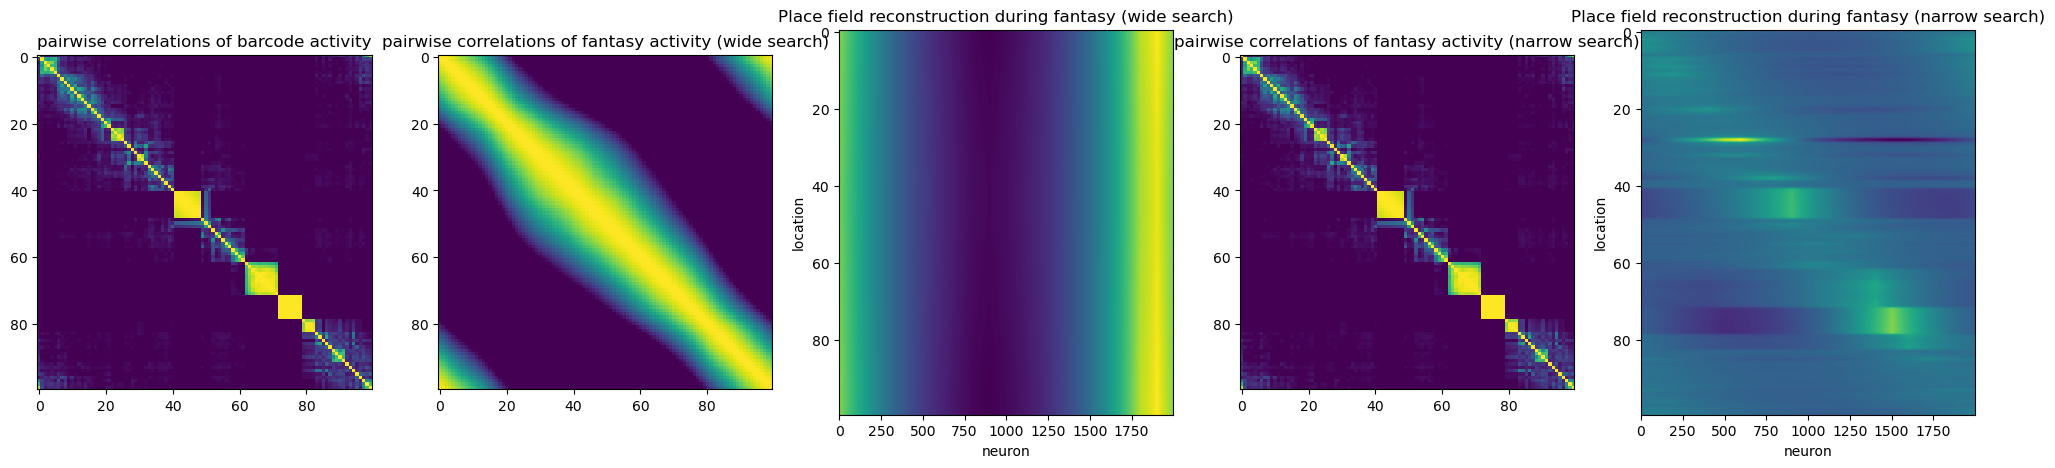

In [104]:
cache_acts = []
input_preacts, input_acts = run_dynamics(0*W_rec, input_strength*inputs+0*W_fantasy, divisive_normalization=divisive_normalization)

plt.imshow(input_acts, vmin=0,  aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("input activity (non-recurrent mode)")
plt.show()

plt.imshow(pairwise_correlations_centered(input_acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of input activity (non-recurrent mode)")
plt.show()

preacts, acts = run_dynamics(W_rec, input_strength*inputs+0*W_fantasy, divisive_normalization=divisive_normalization)

plt.imshow(acts, vmin=0, vmax=1, aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("barcode activity (recurrent mode)")
plt.show()

print('***')
print('sparsity', np.mean(acts>0))    
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of barcode activity (recurrent mode)")
plt.show()

acts_normalized = normalize(acts, ax=0)
inputs_normalized = normalize(input_acts, ax=0)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)
    preacts, acts = run_dynamics(W_rec, input_strength*inputs, divisive_normalization=divisive_normalization)
    cache_acts.append(acts)
    
    W_fantasy += acts[cache_state]
    act = acts[cache_state:cache_state+1]
    preact = preacts[cache_state:cache_state+1]
    delta_W = np.matmul(act.transpose(), preact) + np.matmul(np.ones_like(act.transpose())*plasticity_bias, act)
    W_rec += lr * delta_W / N_bar
    W_reconstruct += inputs[cache_state].reshape(-1, 1) @ acts[cache_state].reshape(1, -1)
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs, divisive_normalization=divisive_normalization) 
    ax[0].set_title("pairwise correlations of barcode activity")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)

    preacts, acts = run_dynamics(W_rec, input_strength*inputs+wide_search_factor*W_fantasy, divisive_normalization=divisive_normalization) 
    ax[1].set_title("pairwise correlations of fantasy activity (wide search)")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    ax[2].set_xlabel("neuron")
    ax[2].set_ylabel("location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction during fantasy (wide search)")
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs+narrow_search_factor*W_fantasy, divisive_normalization=divisive_normalization) 
    ax[3].set_title("pairwise correlations of fantasy activity (narrow search)")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    ax[4].set_xlabel("neuron")
    ax[4].set_ylabel("location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction during fantasy (narrow search)")
    plt.show()
    

# Fig 3ab, Fig 4: cache v. visit correlation

In [105]:
def cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [106]:
def corr(a, b):
    scale = 1.
    poiss_a = poisson(scale*a).rvs()
    poiss_b = poisson(scale*b).rvs()
    return np.corrcoef(poiss_a, poiss_b)[0, 1]

In [107]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}

sim_func = corr
for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        cache_act_i = cache_acts[i][cache_states[i]]
        cache_act_j = cache_acts[j][cache_states[j]]
        _, place_acts_1 = run_dynamics(0.*W_rec, input_strength*inputs+0*W_fantasy)
        _, place_acts_2 = run_dynamics(0.*W_rec, input_strength*inputs+0*W_fantasy)
        
        # Get correlations
        place_act_i = place_acts_1[cache_states[i]]
        place_act_j = place_acts_2[cache_states[j]]
        
        for _ in range(2):
            cache_scale = 1.
            place_scale = 0.5
            c_c_corr = sim_func(cache_act_i*cache_scale, cache_act_j*cache_scale)
            c_v_corr = sim_func(cache_act_i*cache_scale, place_act_j*place_scale)
            v_v_corr = sim_func(place_act_i*place_scale, place_act_j*place_scale)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)

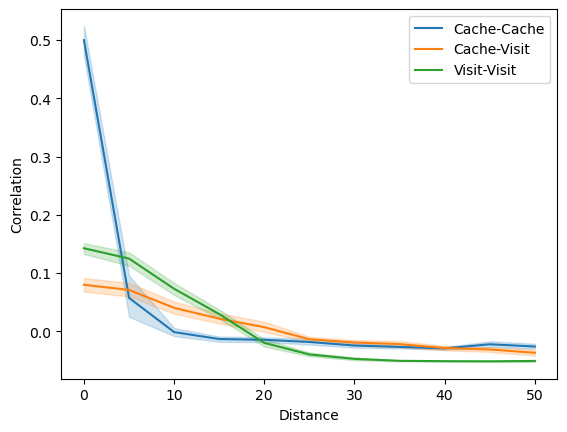

In [108]:
plt.figure()
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Cache', color='C0',
    data=pd.DataFrame(cache_cache_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Visit', color='C1',
    data=pd.DataFrame(cache_visit_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Visit-Visit', color='C2',
    data=pd.DataFrame(visit_visit_corr))
plt.legend()
plt.show()

# Fig 3c: Example barcodes

In [110]:
_, place_act = run_dynamics(0.*W_rec, input_strength*inputs+0*W_fantasy)

In [120]:
place_mean = np.mean(place_act, axis=0)

In [121]:
locations = []
barcodes = []
_, place_act = run_dynamics(0.*W_rec, input_strength*inputs+0*W_fantasy)
for i in range(len(cache_states)):
    location = cache_states[i]
    _cache_act = cache_acts[i][location]
    _place_act = place_act[location]
    _place_act = _place_act - place_mean
    _place_act /= np.linalg.norm(_place_act)
    projection = np.dot(_cache_act, _place_act) * _place_act
    locations.append(location)
    barcodes.append(_cache_act - projection)

In [122]:
x = np.array(barcodes)

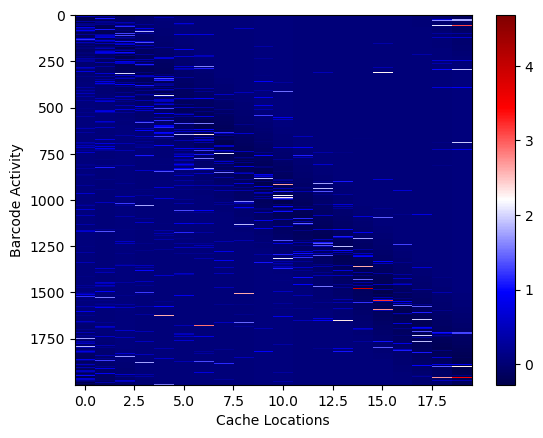

In [134]:
plt.figure()
plt.imshow(x.T, cmap='seismic', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xlabel('Cache Locations')
plt.ylabel('Barcode Activity')
plt.show()

# Fig 2: Barcode neuron participation